# Training U-Net for Image Segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils.utils as utils
import torch
from torch.utils.data import DataLoader
import utils.load_dataset as loader
import numpy as np
from collections import Counter
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import random
import os
from glob import glob
from torchvision.transforms import v2
from torchgeo.models import resnet18
from torchgeo.models import ResNet18_Weights
from torchsummary import summary
import utils.train as t
import model.unet as model
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from torch.autograd import Variable

/home/ubuntu/miniconda3/envs/conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Loading Dataset

In [4]:
image_paths = sorted(glob("data/pred_patches/images/*.npy"))
mask_paths = sorted(glob("data/pred_patches/masks/*.npy"))
dataset = loader.SatelliteDataset(image_paths, mask_paths)
print(len(dataset))

7056


## Data Preprocessing

### Data Exploration
Explore Ground Truth mask 

Tree cover (0): 57868482 pixels
Shrubland (1): 6339032 pixels
Grassland (2): 19099534 pixels
Cropland (3): 5261929 pixels
Built-up (4): 1638732 pixels
Bare/sparse veg. (5): 681612 pixels
Permanent water bodies (7): 29029993 pixels
Herbaceous wetland (8): 608146 pixels


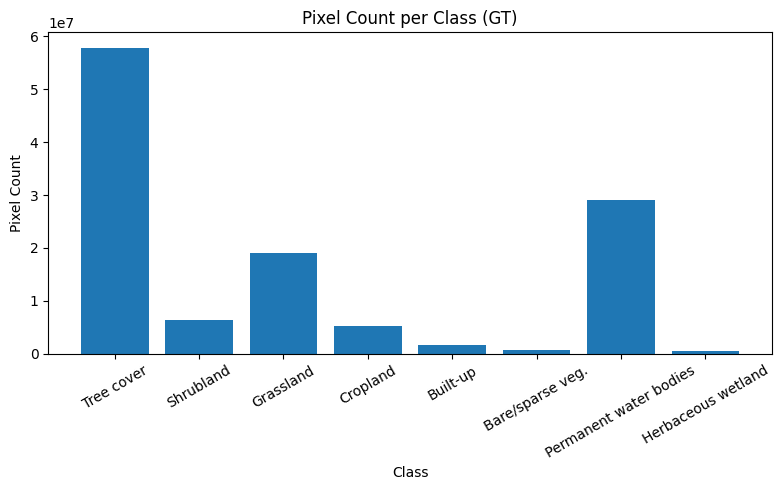

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Snow and ice",
    7: "Permanent water bodies",
    8: "Herbaceous wetland",
    9: "Mangroves",
    10: "Moss/lichen",
}
label_mapping = {
    10: 0,
    20: 1,
    30: 2,
    40: 3,
    50: 4,
    60: 5,
    70: 6,
    80: 7,
    90: 8,
    95: 9,
    100: 10,
}

gt_path = "data/prediction/GBDA24_ex2_34SEH_ref_data.tif"
with rasterio.open(gt_path) as src:
    raw_mask = src.read(1)

mask = np.full(raw_mask.shape, fill_value=-1, dtype=np.int16)

for raw_val, new_val in label_mapping.items():
    mask[raw_mask == raw_val] = new_val

mask = mask[mask != -1]

unique_classes, counts = np.unique(mask, return_counts=True)
labels = [class_names[c] for c in unique_classes]

for c, count in zip(unique_classes, counts):
    print(f"{class_names[c]} ({c}): {count} pixels")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title("Pixel Count per Class (GT)")
plt.ylabel("Pixel Count")
plt.xlabel("Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Clean dataset from NaN values

In [6]:
valid = []
for i in range(len(dataset)):
    image, mask = dataset[i]
    if not (image == -9999).any().item():
        valid.append(i)

print("Initial size of dataset:", len(dataset))
clean_dataset = Subset(dataset, valid)
print("size of cleaned dataset:", len(clean_dataset))

Initial size of dataset: 7056
size of cleaned dataset: 6889


Straify Sampling because of inbalanced dataset

### Normalization and Augmentation

In [8]:
val_transform = loader.Compose([loader.Normalize13Band()], with_mask=True)
val_dataset = loader.TorchDataset(clean_dataset, val_transform)

In [9]:
ds_test = DataLoader(val_dataset, batch_size=32, shuffle=True)

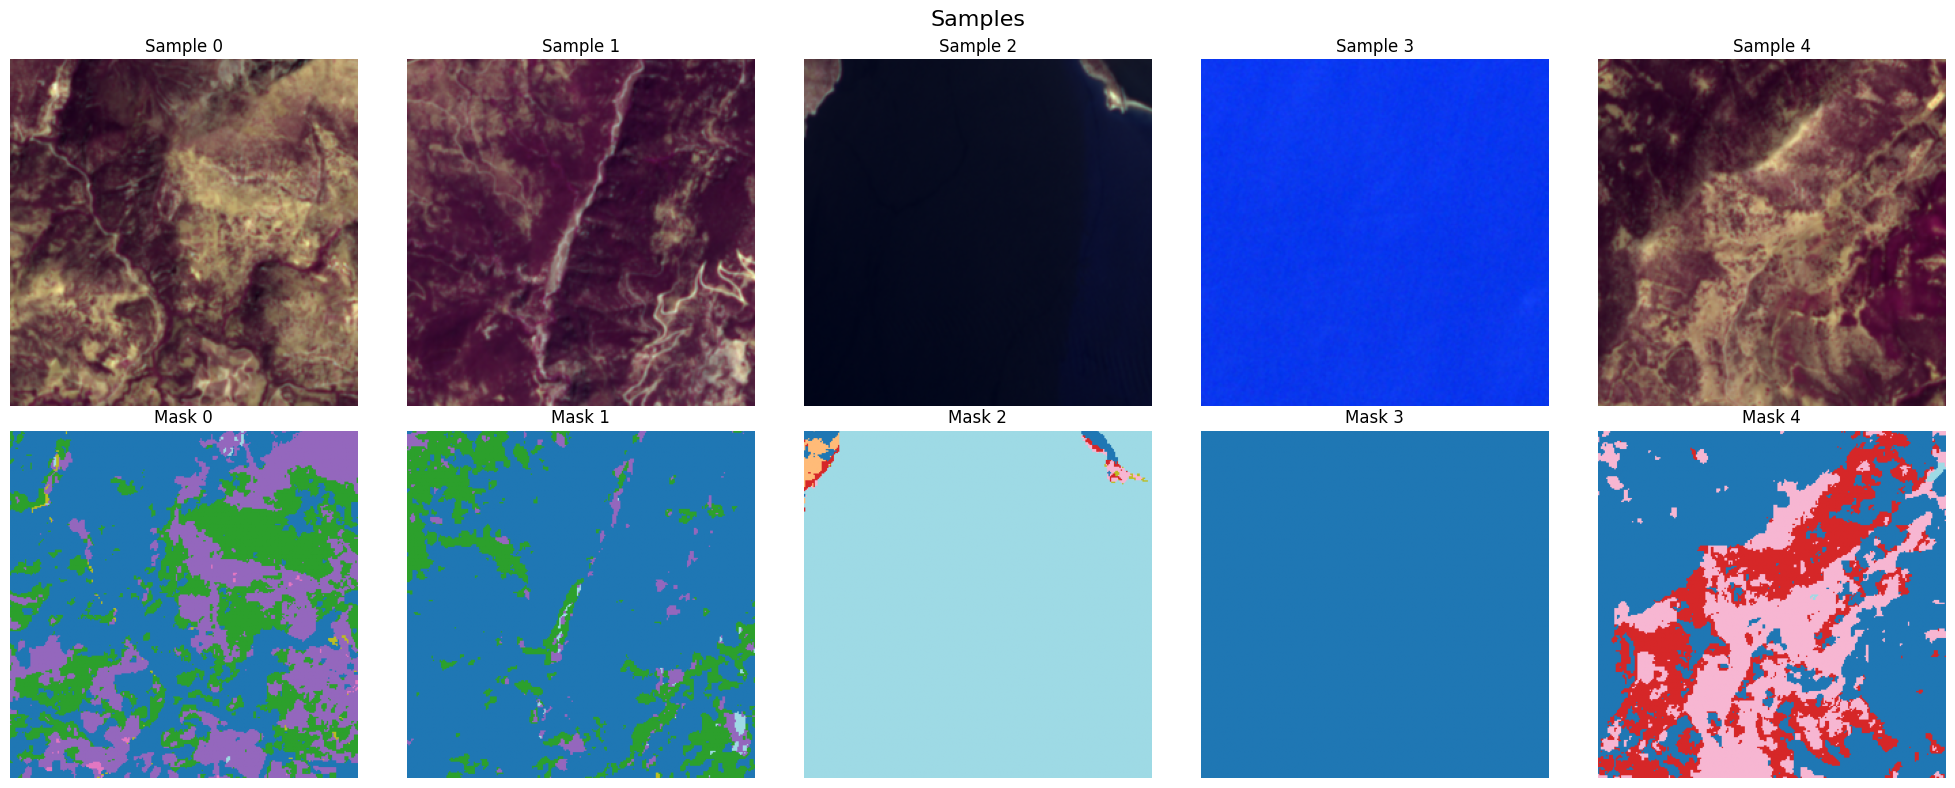

In [10]:
x_batch, y_batch = next(iter(ds_test))  # one batch from training
utils.visualize_samples(
    x_list=[x_batch[i] for i in range(5)],
    y_list=[y_batch[i] for i in range(5)],
    bands=(4, 3, 2),
)

## Model Inference

In [11]:
unet = model.UNet(num_classes=8)
unet.load_state_dict(torch.load("output/exp_01_1_hybrid_loss.pt"))
unet.to(device)
avg_loss, avg_acc, avg_dice = t.evaluate_model(unet, ds_test)
t.segmentation_report(unet, ds_test)

Evaluating: 100%|██████████| 216/216 [00:42<00:00,  5.10it/s]



 Evaluation Results:
  | Pixel Accuracy: 85.02% | Dice Score: 0.8329 | Mean IoUScore: 0.3058
=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.8848    0.9308    0.9072 217451295
     Class 1     0.6810    0.1005    0.1751  23473443
     Class 2     0.6813    0.7245    0.7022  70871360
     Class 3     0.5936    0.7142    0.6483  20366728
     Class 4     0.5323    0.5840    0.5570   6354450
     Class 5     0.4877    0.5053    0.4963   2466843
     Class 6     0.9919    0.9959    0.9939 108064229
     Class 7     0.4533    0.2505    0.3227   2429156

    accuracy                         0.8502 451477504
   macro avg     0.6632    0.6007    0.6003 451477504
weighted avg     0.8453    0.8502    0.8357 451477504

=== Dice per Class ===
Class 0: 0.9072
Class 1: 0.1751
Class 2: 0.7022
Class 3: 0.6483
Class 4: 0.5570
Class 5: 0.4963
Class 6: 0.9939
Class 7: 0.3227
